In [1]:
import torch
import lib.utils.bookkeeping as bookkeeping
from torch.utils.data import DataLoader
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import lib.models.models as models
import lib.models.model_utils as model_utils
from lib.datasets import mnist, maze, protein, synthetic
import lib.datasets.dataset_utils as dataset_utils
import lib.losses.losses as losses
import lib.losses.losses_utils as losses_utils
import lib.training.training as training
import lib.training.training_utils as training_utils
import lib.optimizers.optimizers as optimizers
import lib.optimizers.optimizers_utils as optimizers_utils
import lib.sampling.sampling as sampling
import lib.sampling.sampling_utils as sampling_utils
import os
from lib.datasets.maze import maze_acc
from ruamel.yaml.scalarfloat import ScalarFloat

In [2]:
# creating paths


path = 'SavedModels/Synthetic/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-20' # 2
config_name = 'config_001_hollowCEProb500K.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_9999_hollowCEProb500K.pt'


path = 'SavedModels/Synthetic/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-20' # 2
config_name = 'config_001_hollowCEProb500K.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_9999_hollowCEProb500K.pt'

path = 'SavedModels/SyntheticRMDirect/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-20' # 2
config_name = 'config_001_hollowCEDirect500K.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_hollowCEDirect500K.pt'

path = "SavedModels/SyntheticBert/"
date = '2023-12-20' # 2
config_name = 'config_001_bert500K.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_bert500K.pt'

path = "SavedModels/SyntheticMasked/"
date = '2023-12-17' # 2
config_name = 'config_001_maskeddirect.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_maskeddirect.pt'



path = "SavedModels/SyntheticBert/"
date = '2023-12-20' # 2
config_name = 'config_001_bert500K.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_bert500K.pt'

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-14' # 2
config_name = 'config_001_unet.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_unet.pt' #  model_299999_hollowMLEProb.pt


path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_bert.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_19999_bert.pt' #  model_299999_hollowMLEProb.pt

path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_299999_hollow8M.pt' #  model_299999_hollowMLEProb.pt

path = 'SavedModels/MNIST/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-20' # 2
config_name = 'config_001_unet14Mlogits.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_349999.pt'



path = 'SavedModels/BIN-MNIST/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-17' # 2
config_name = 'config_001_unet3M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_199999_unet3M.pt' 


path = 'SavedModels/MNIST/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-20' # 2
config_name = 'config_001_unet14Mlogits.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_349999.pt'



path = 'SavedModels/MAZE/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-22' # 2
config_name = 'config_001_hollow8M.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_49999_hollow8M.pt' #  model_299999_hollowMLEProb.pt



path = 'SavedModels/MAZEunet/' # 'SavedModels/MAZE/' 'SavedModels/MNIST/'
date = '2023-12-23' # 2
config_name = 'config_001.yaml' # config_001_hollowMLEProb.yaml
model_name = 'model_9999.pt' #  model_299999_hollowMLEProb.pt

path = 'SavedModels/MAZEprotein/'
date = "2023-12-23"
config_name = "config_001_score.yaml"
model_name = "model_199999_score.pt"


config_path = os.path.join(path, date, config_name)
checkpoint_path = os.path.join(path, date, model_name)

In [3]:
# creating models
cfg = bookkeeping.load_config(config_path)
cfg.sampler.name = 'MidPointTauL' #ExactSampling' # ElboLBJF CRMTauL CRMLBJF
cfg.sampler.num_corrector_steps = 0
cfg.sampler.corrector_entry_time = ScalarFloat(0.0)
cfg.sampler.num_steps = 1000
cfg.sampler.is_ordinal = False

#print(cfg)
device = torch.device(cfg.device)

model = model_utils.create_model(cfg, device)
print("number of parameters: ", sum([p.numel() for p in model.parameters()]))

#modified_model_state = utils.remove_module_from_keys(loaded_state['model'])
#model.load_state_dict(modified_model_state)
#optimizer = optimizers_utils.get_optimizer(model.parameters(), cfg)
optimizer = torch.optim.Adam(model.parameters(), cfg.optimizer.lr)

sampler = sampling_utils.get_sampler(cfg)

state = {"model": model, "optimizer": optimizer, "n_iter": 0}
state = bookkeeping.load_state(state, checkpoint_path)
state['model'].eval()

number of parameters:  8102704
ema state dict function


In [4]:
n_samples = 64
samples, changes = sampler.sample(model, n_samples)
saved_samples = samples

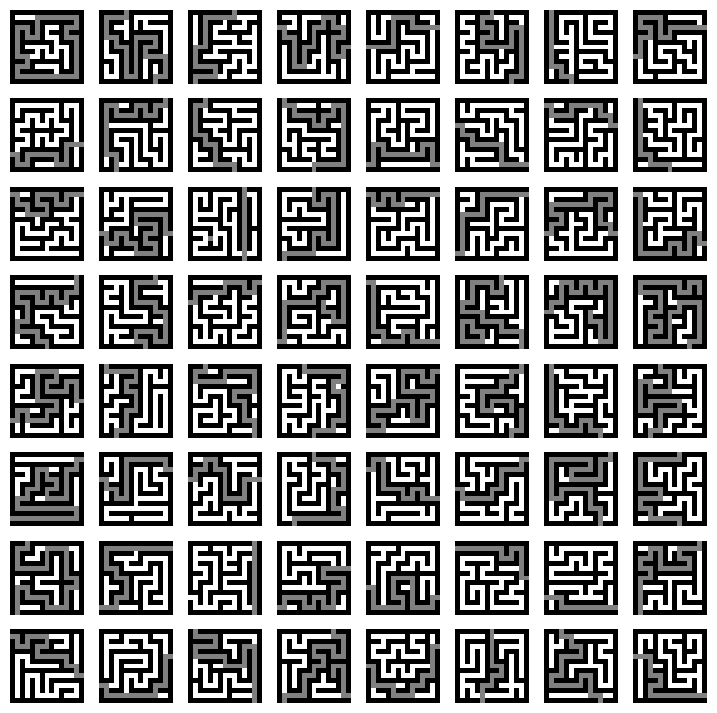

In [5]:
is_img = True

if is_img:
    samples = samples.reshape(n_samples, 1, cfg.data.image_size, cfg.data.image_size)
    saving_train_path = os.path.join(cfg.saving.sample_plot_path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
    fig = plt.figure(figsize=(9, 9)) 
    for i in range(n_samples):
        plt.subplot(int(np.sqrt(n_samples)), int(np.sqrt(n_samples)), 1 + i)
        plt.axis("off")
        plt.imshow(np.transpose(samples[i, ...], (1,2,0)), cmap="gray")
 
 
    plt.savefig(saving_train_path)
    plt.show()
    plt.close()
else:
    bm, inv_bm = synthetic.get_binmap(cfg.model.concat_dim, cfg.data.binmode)
    print(inv_bm)
    samples = synthetic.bin2float(samples.astype(np.int32), inv_bm, cfg.model.concat_dim, cfg.data.int_scale)

 
    saving_plot_path = os.path.join(path, f"{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.png")
    saving_np_path = os.path.join(path, f"samples_{cfg.model.name}{state['n_iter']}_{cfg.sampler.name}{cfg.sampler.num_steps}.npy")
    np.save(f'{saving_np_path}', samples)

    #aving_plot_path = '/Users/paulheller/PythonRepositories/Master-Thesis/ContTimeDiscreteSpace/TAUnSDDM/SavedModels/MNIST/'
    synthetic.plot_samples(samples, saving_plot_path, im_size=cfg.data.plot_size, im_fmt="png")

0
6
18
27
28
29
30
31
35
37
59
Accuracy: From 64 are 82.8125% solvable.


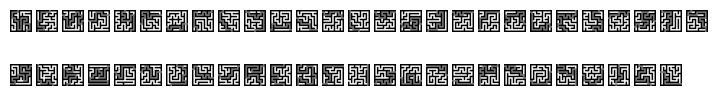

In [6]:
correct_mazes = maze_acc(saved_samples)
correct_mazes = correct_mazes[:, np.newaxis, :, :]

fig = plt.figure(figsize=(9, 2)) 
n_c = correct_mazes.shape[0]
n_cols = 2
if n_c % 2 == 0:
    n_rows = int(n_c / n_cols)
else:
    n_rows = int(np.ceil(n_c /n_cols))
    #n_c = n_c - 1
    n_cols = 3
for i in range(n_c):
    plt.subplot(n_cols, n_rows, 1 + i)
    plt.axis("off")
    plt.imshow(np.transpose(correct_mazes[i, ...], (1,2,0)), cmap="gray")
plt.show()
 


[]


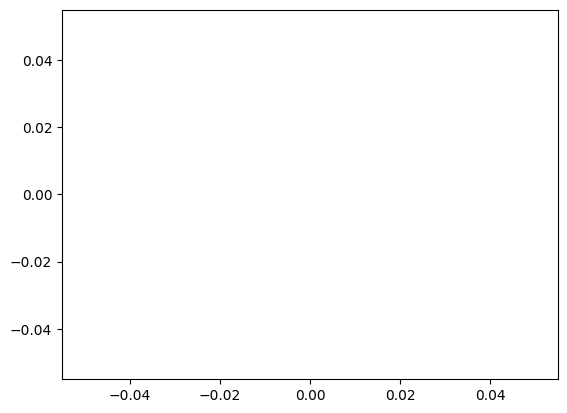

In [7]:
plt.plot(changes)
print(changes)
plt.show()